# Create a regular gridded dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import verde as vd
import harmonica as hm
import pyproj
from pathlib import Path
import tarfile
from io import StringIO
import itertools

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Crop survey area

In [3]:
tar_path = Path('../data/1038_XYZ.tar.xz')
file_path = Path('1038_XYZ/1038/spaulo_rjaneiro_rj.xyz')
file_content = None
with tarfile.open(tar_path, 'r') as tar:
    for member in tar.getmembers():
        if Path(member.name) == file_path:
            file_content = tar.extractfile(member).read().decode('ISO-8859-1')
            break
if file_content is None:
    raise FileNotFoundError(f"The specified file '{file_path}' was not found in the tar archive.")

lines = file_content.splitlines()
filtered_lines = [line for line in lines if not (line.startswith('LINE') or line.startswith('TIE'))]
filtered_data = '\n'.join(filtered_lines)
filtered_data_io = StringIO(filtered_data)

column_names = [
    'easting_m', 'northing_m', 'longitude', 'latitude', 'tfa_nT', 'THC', 'UC', 'KC', 'CTC', 
    'MAGB', 'MAGC', 'MAGD', 'THB', 'UB', 'KB', 'CTB', 'FIDU', 'TEMP', 
    'height_m', 'ALTB'
]
use_columns = [
    'longitude', 'latitude', 'tfa_nT', 'height_m',
]
df = pd.read_csv(filtered_data_io, 
                 delim_whitespace=True,
                 names=column_names,
                 usecols=use_columns,
                 skiprows=6)
df

,longitude,latitude,tfa_nT,height_m
0,-43.995255,-23.099503,434.32,300.00
1,-43.995224,-23.098618,426.28,300.00
2,-43.995193,-23.097733,418.24,300.00
3,-43.995178,-23.096832,410.20,300.00
4,-43.995148,-23.095947,402.16,300.00
...,...,...,...,...
433231,-41.949890,-20.818878,184.03,241.71
433232,-41.950882,-20.818909,179.13,241.10
433233,-41.951859,-20.818909,174.23,238.66
433234,-41.952850,-20.818924,167.32,234.70


In [4]:
# Crop area
region = [-42.65, -41.95, -22.55, -21.85]
mask = vd.inside(coordinates=[df.longitude, df.latitude], region=region)
data = df[mask]

In [5]:
# Project coordinates
projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.mean())
easting, northing = projection(data.longitude.values, data.latitude.values)
coordinates = [easting, northing, data.height_m]

data = data.assign(easting_m=easting)
data = data.assign(northing_m=northing)
data

,longitude,latitude,tfa_nT,height_m,easting_m,northing_m
147806,-42.646378,-22.549759,161.74,228.60,-4.397578e+06,-2.372560e+06
147807,-42.646393,-22.548859,162.67,220.07,-4.397579e+06,-2.372461e+06
147808,-42.646408,-22.547958,163.61,210.92,-4.397581e+06,-2.372360e+06
147809,-42.646439,-22.547043,164.55,201.78,-4.397584e+06,-2.372259e+06
147810,-42.646454,-22.546143,164.49,192.33,-4.397586e+06,-2.372159e+06
...,...,...,...,...,...,...
424373,-41.986664,-21.892532,117.10,204.83,-4.329550e+06,-2.299772e+06
424374,-41.987457,-21.892517,116.17,214.58,-4.329632e+06,-2.299770e+06
424375,-41.988266,-21.892502,116.23,221.89,-4.329715e+06,-2.299768e+06
424376,-41.989075,-21.892471,115.30,224.03,-4.329799e+06,-2.299765e+06


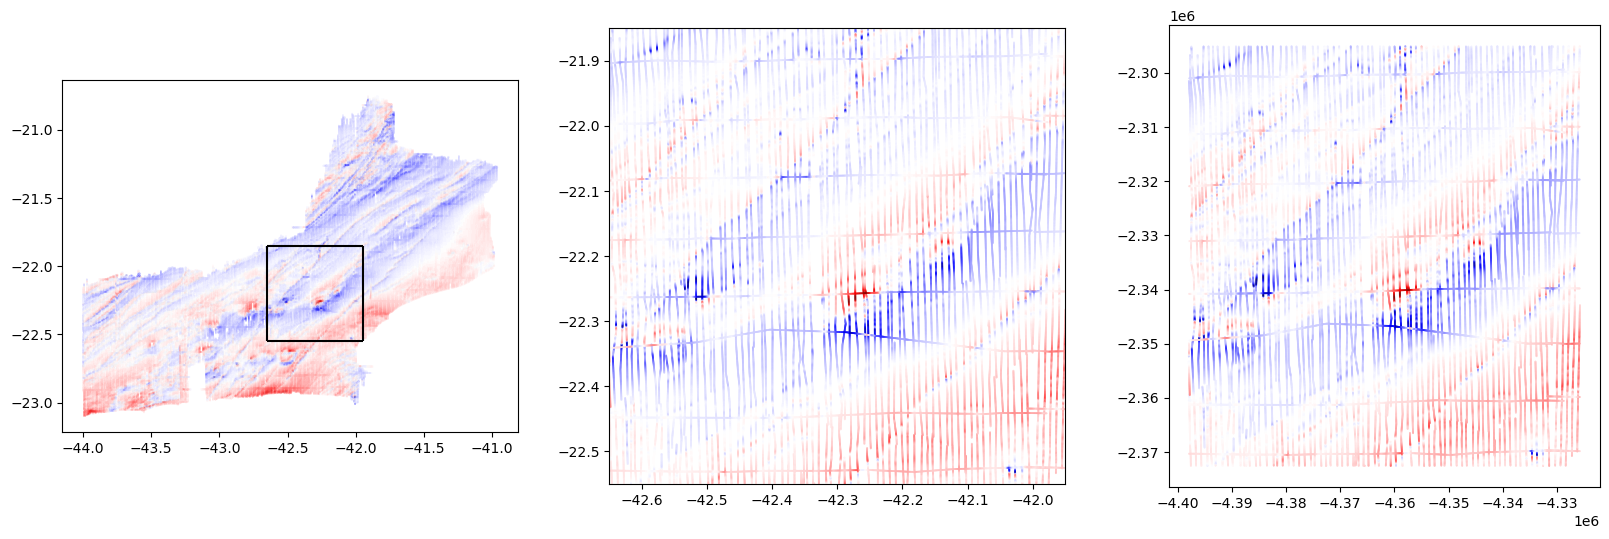

In [6]:
plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
plt.scatter(df.longitude, df.latitude, s=0.001, c=df.tfa_nT, cmap='seismic')
plt.axis('scaled')
plt.vlines(x=[region[0], region[1]], ymin=region[2], ymax=region[3], color='black')
plt.hlines(y=[region[2], region[3]], xmin=region[0], xmax=region[1], color='black')
plt.subplot(1,3,2)
plt.scatter(data.longitude, data.latitude, s=0.1, c=data.tfa_nT, cmap='seismic')
plt.axis('scaled')
plt.xlim(region[0], region[1])
plt.ylim(region[2], region[3])
plt.subplot(1,3,3)
plt.scatter(data.easting_m, data.northing_m, s=0.1, c=data.tfa_nT, cmap='seismic')
plt.axis('scaled')
plt.show()

## Interpolate data onto a regular grid using GB EQS

In [7]:
damping = 1e0
depth = 2e3
grid_spacing = 0.1e3

eqs = hm.EquivalentSourcesGB(
    depth=depth,
    damping=damping,
    block_size=grid_spacing,
    window_size=20e3,
    random_state=0,
)
eqs.fit(coordinates, data.tfa_nT)

EquivalentSourcesGB(block_size=100.0, damping=1.0, depth=2000.0, random_state=0,
                    window_size=20000.0)

In [8]:
grid_region = vd.get_region(coordinates)
grid_coords = vd.grid_coordinates(
    region=grid_region,
    spacing=grid_spacing,
    extra_coords=data.height_m.max(),
)
grid_tfa_nT = eqs.predict(grid_coords)
grid_data = vd.make_xarray_grid(grid_coords, data=grid_tfa_nT, data_names="tfa_nT", dims=('northing_m', 'easting_m'), extra_coords_names='height_m')
grid_data

<xarray.Dataset> Size: 9MB
Dimensions:     (northing_m: 776, easting_m: 723)
Coordinates:
  * easting_m   (easting_m) float64 6kB -4.398e+06 -4.398e+06 ... -4.326e+06
  * northing_m  (northing_m) float64 6kB -2.373e+06 -2.372e+06 ... -2.295e+06
    height_m    (northing_m, easting_m) float64 4MB 300.0 300.0 ... 300.0 300.0
Data variables:
    tfa_nT      (northing_m, easting_m) float64 4MB 155.6 156.5 ... 126.9 124.2

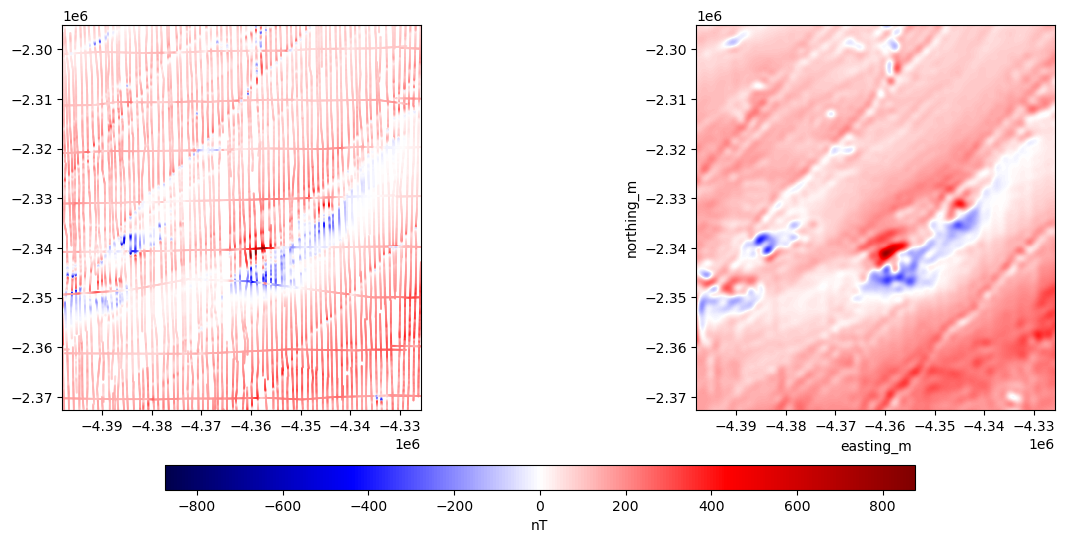

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes = axes.ravel()
ax = axes[0]
scale = vd.maxabs(data.tfa_nT)
ax.scatter(
    data.easting_m,
    data.northing_m,
    c=data.tfa_nT,
    s=0.1,
    cmap="seismic",
    vmin=-scale,
    vmax=scale,
)
ax.set_xlim(grid_region[0], grid_region[1])
ax.set_ylim(grid_region[2], grid_region[3])
ax.set_aspect("equal")

ax = axes[1]
tmp = grid_data.tfa_nT.plot.pcolormesh(
    cmap="seismic",
    vmin=-scale,
    vmax=scale,
    add_colorbar=False,
)
ax.set_aspect("equal")
cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.05, shrink=0.9)
fig.colorbar(tmp, **cbar_kwargs,  label="nT", cax=fig.add_axes([0.25, -0.05, 0.5, 0.05]))
plt.show()

### 2 EQS layers

In [10]:
deep_damping = 1
deep_depth = 1e3
grid_spacing = 0.1e3

deep_layer = hm.EquivalentSourcesGB(
    depth=deep_depth,
    damping=deep_damping,
    block_size=grid_spacing,
    window_size=20e3,
    random_state=0,
)
deep_layer.fit(coordinates, data.tfa_nT)
deep_tfa = deep_layer.predict(coordinates)
deep_residual = data.tfa_nT - deep_tfa
deep_tfa_grid = deep_layer.predict(grid_coords)

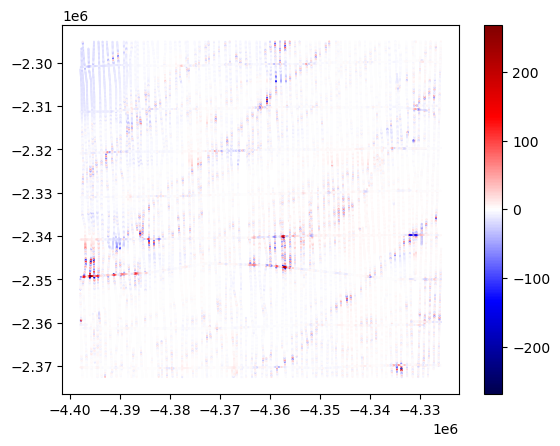

In [11]:
scale = vd.maxabs(deep_residual)
plt.figure()
plt.scatter(coordinates[0], coordinates[1], c=deep_residual, cmap="seismic", s=0.1, vmin=-scale, vmax=scale)
plt.colorbar()
plt.show()

In [12]:
shallow_damping = 1e5
shallow_depth = 0.5e3
shallow_layer = hm.EquivalentSourcesGB(
    depth=shallow_depth,
    damping=shallow_damping,
    block_size=grid_spacing,
    window_size=20e3,
    random_state=0,
)
shallow_layer.fit(coordinates, deep_residual)
tfa_predict = deep_tfa_grid + shallow_layer.predict(grid_coords)

In [13]:
tfa_two_layers = vd.make_xarray_grid(grid_coords, data=tfa_predict, data_names="tfa_nT", dims=('northing_m', 'easting_m'), extra_coords_names='height_m')

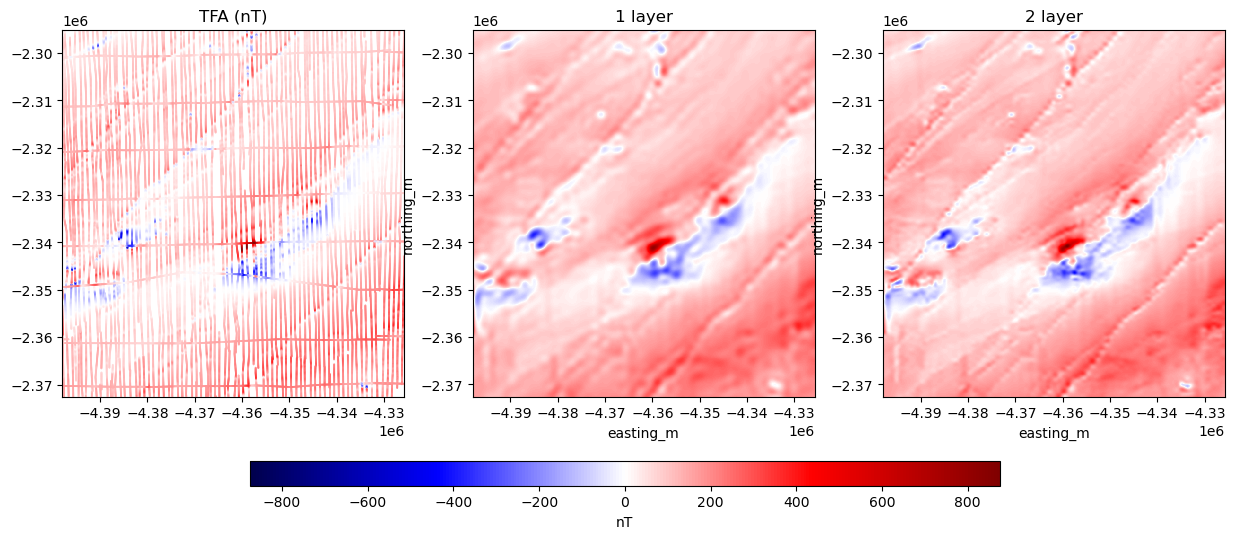

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.ravel()
ax = axes[0]
scale = vd.maxabs(data.tfa_nT)
ax.scatter(
    data.easting_m,
    data.northing_m,
    c=data.tfa_nT,
    s=0.1,
    cmap="seismic",
    vmin=-scale,
    vmax=scale,
)
ax.set_xlim(grid_region[0], grid_region[1])
ax.set_ylim(grid_region[2], grid_region[3])
ax.set_aspect("equal")
ax.set_title('TFA (nT)')

ax = axes[1]
tmp = grid_data.tfa_nT.plot.pcolormesh(
    ax=ax,
    cmap="seismic",
    vmin=-scale,
    vmax=scale,
    add_colorbar=False,
)
ax.set_aspect("equal")
ax.set_title('1 layer')

ax = axes[2]
tmp1 = tfa_two_layers.tfa_nT.plot.pcolormesh(
    ax=ax,
    cmap="seismic",
    vmin=-scale,
    vmax=scale,
    add_colorbar=False,
)
ax.set_aspect("equal")
ax.set_title('2 layer')
cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.05, shrink=0.9)
fig.colorbar(tmp, **cbar_kwargs,  label="nT", cax=fig.add_axes([0.25, -0.05, 0.5, 0.05]))
plt.show()

## Save data

In [17]:
data_path = Path('../data/rio-magnetic.nc') 
grid_data.to_netcdf(data_path, format='NETCDF4')